In [2]:
import requests
import pandas as pd

def get_player_average_rating(player_id: int) -> float:
    """
    Fetches and returns the average rating of a player from the SportMonks API for a given player ID and season ID.
    
    Parameters:
    - player_id (int): The ID of the player.
    - season_id (int): The ID of the season.
    
    Returns:
    - float: The average rating of the player.
    """
    
    # Ensure the inputs are integers
    if not isinstance(player_id, int):
        raise TypeError("Player ID and Season ID must be integers.")
    
    # API request
    url = f"https://api.sportmonks.com/v3/football/players/{player_id}?api_token={api_token}&include=statistics.details.type&filters=playerStatisticSeasons:21646"
    response = requests.get(url)
    
    # Check for request failure
    if response.status_code != 200:
        raise ConnectionError(f"Failed to fetch data from API. Status code: {response.status_code}")
    
    data = response.json()
    
    # Extracting player statistics
    try:
        player_statistics = data['data']['statistics'][0]['details']
    except (KeyError, IndexError):
        raise ValueError("Failed to extract player statistics from API response.")
    
    # Extracting average rating
    average_rating = None
    for stat in player_statistics:
        if stat['type']['name'] == 'Rating':
            average_rating = stat['value']['total'] if isinstance(stat['value'], dict) and 'total' in stat['value'] else stat['value']
            break
    
    if average_rating is None:
        raise ValueError("Failed to find average rating in player statistics.")
    
    return average_rating.get('average')

def get_player_consistency_rating(player_id: int) -> float:
    """
    Fetches and returns the consistency rating of a player from the SportMonks API for a given player ID and season ID.
    
    Parameters:
    - player_id (int): The ID of the player.
    - season_id (int): The ID of the season.
    
    Returns:
    - float: The consistency rating of the player.
    """
    
    # Ensure the inputs are integers
    if not isinstance(player_id, int):
        raise TypeError("Player ID and Season ID must be integers.")
    
    # API request
    url = f"https://api.sportmonks.com/v3/football/players/{player_id}?api_token={api_token}&include=statistics.details.type&filters=playerStatisticSeasons:21646"
    response = requests.get(url)
    
    # Check for request failure
    if response.status_code != 200:
        raise ConnectionError(f"Failed to fetch data from API. Status code: {response.status_code}")
    
    data = response.json()
    
    # Extracting player statistics
    try:
        player_statistics = data['data']['statistics'][0]['details']
    except (KeyError, IndexError):
        raise ValueError("Failed to extract player statistics from API response.")
    
    # Extracting average rating
    average_rating = None
    for stat in player_statistics:
        if stat['type']['name'] == 'Rating':
            average_rating = stat['value']['total'] if isinstance(stat['value'], dict) and 'total' in stat['value'] else stat['value']
            break
    
    if average_rating is None:
        raise ValueError("Failed to find average rating in player statistics.")
    
    return -(average_rating.get('highest')-average_rating.get('lowest'))

In [3]:
api_token = 'WPlkXKJHDUEu3HehTDHs4sUg2OQhJiSQ3k5bSOB8r4REsFBIhydo3Z0F9Wsr'


def extract_player_data(fixture_id:int):
    """
    Extracts relevant player data from a list of player data objects and returns it as a DataFrame.
    
    Parameters:
    - player_data_list (list): A list of dictionaries containing player data.
    
    Returns:
    - pd.DataFrame: A DataFrame containing the extracted data.
    """
    url = f'https://api.sportmonks.com/v3/football/fixtures/{fixture_id}?api_token={api_token}&include=participants;events;statistics;lineups.player:display_name,image_path;lineups.player.country:name,image_path;lineups.details.type'

    response = requests.get(url)
    data = response.json()
    player_data_list = data['data']['lineups']
    player_ids = []
    team_ids = []
    image_paths = []
    names = []
    positions = []
    details = []
    detailed_positions = []
    
    position_mapping = {
    24: "Goalkeeper",
    25: "Defender",
    26: "Midfielder",
    27: "Attacker",
    28: "Unknown",
    148: "Centre Back",
    149: "Defensive Midfield",
    150: "Attacking Midfield",
    151: "Centre Forward",
    152: "Left Wing",
    153: "Central Midfield",
    154: "Right Back",
    155: "Left Back",
    156: "Right Wing",
    157: "Left Midfield",
    158: "Right Midfield",
    163: "Secondary Striker",
    221: "Coach",
    226: "Assistant Coach",
    227: "Goalkeeping Coach",
    228: "Forward Coach",
    560: "Caretaker Manager"
    }
    
    for player_data in player_data_list:
        if 'details' in player_data and player_data['details']:
            player_ids.append(player_data['player_id'])
            team_ids.append(player_data['team_id'])
            image_paths.append(player_data['player']['image_path'])
            names.append(player_data['player_name'])
            positions.append(player_data['player']['position_id'])
            detailed_positions.append(player_data['player']['detailed_position_id'] if player_data['player'].get('detailed_position_id') !=None else None)

    df = pd.DataFrame({
        'player_id': player_ids,
        'team_id': team_ids,
        'image_path': image_paths,
        'name': names,
        'position': positions,
        'detailed_position': detailed_positions,
    })
    
    df['detailed_position'].fillna(df['position'], inplace=True)

    df['detailed_position'] = df['detailed_position'].astype(int)

    df['position_name'] = df['detailed_position'].map(position_mapping)
    df['broad_position'] = df['position'].map(position_mapping)


    return df

df = extract_player_data(18841683)
df['average_rating'] = df['player_id'].apply(lambda x: get_player_average_rating(x))
df['consistency_rating'] = df['player_id'].apply(lambda x: get_player_consistency_rating(x))
def minmax_normalize(series, scale_min=0, scale_max=10):
    return (series - series.min()) / (series.max() - series.min()) * (scale_max - scale_min) + scale_min
df['normalized_consistency'] = minmax_normalize(df['consistency_rating'])
df.head(5)

,player_id,team_id,image_path,name,position,detailed_position,position_name,broad_position,average_rating,consistency_rating,normalized_consistency
0,540579,6,https://cdn.sportmonks.com/images/soccer/playe...,Oliver Skipp,26,149,Defensive Midfield,Midfielder,6.71,-0.61,8.342391
1,1744,6,https://cdn.sportmonks.com/images/soccer/playe...,Pierre-Emile Højbjerg,26,153,Central Midfield,Midfielder,6.87,-0.91,7.527174
2,4313,6,https://cdn.sportmonks.com/images/soccer/playe...,Heung-min Son,27,152,Left Wing,Attacker,7.88,-2.76,2.500000
3,96870,6,https://cdn.sportmonks.com/images/soccer/playe...,Yves Bissouma,26,153,Central Midfield,Midfielder,7.48,-1.84,5.000000
4,219633,6,https://cdn.sportmonks.com/images/soccer/playe...,Richarlison,27,151,Centre Forward,Attacker,6.78,-1.63,5.570652


In [4]:
df.to_csv('players_data.csv',index=False)

In [149]:
#time series team stats
def calculate_scored_conceded(data,team_id):
    scored = [obj for obj in data if obj['participant_id']==team_id]
    first_half_scored = scored[1]['score']['goals']
    second_half_scored = scored[2]['score']['goals']
    home_away = scored[0]['score']['participant']
    conceded = [obj for obj in data if obj['participant_id']!=team_id]
    first_half_conceded = conceded[1]['score']['goals']
    second_half_conceded = conceded[2]['score']['goals']
    
    return {
        '1st_half_scored': first_half_scored,
        '2nd_half_scored': second_half_scored,
        '1st_half_conceded': first_half_conceded,
        '2nd_half_conceded': second_half_conceded,
        'home_away': home_away
    }

def get_team_stats_lookback(api_token, start_date, end_date, team_id, team_name):
    """
    Fetches and returns the team statistics from the SportMonks API for a given date range and team.
    Parameters:
    - api_token (str): API token for accessing the SportMonks API.
    - start_date (str): Start date in the format 'YYYY-MM-DD'.
    - end_date (str): End date in the format 'YYYY-MM-DD'.
    - team_id (int): The ID of the team.
    - team_name (str): The name of the team.
    Returns:
    - pd.DataFrame: A DataFrame containing the team statistics.
    """
    
    if not isinstance(api_token, str) or not isinstance(start_date, str) or not isinstance(end_date, str) or not isinstance(team_id, int) or not isinstance(team_name, str):
        raise TypeError("Invalid input type. Please ensure all inputs are of the correct type.")
    
    url = f'https://api.sportmonks.com/v3/football/fixtures/between/{start_date}/{end_date}?api_token={api_token}&include=participants;scores;statistics.type;&filters=participantSearch:{team_name}'
    response = requests.get(url)
    
    if response.status_code != 200:
        raise ConnectionError(f"Failed to fetch data from API. Status code: {response.status_code}")
    
    data = response.json()
    scores = [
        [
            score for score in fixture['scores']
            
        ]
        for fixture in data['data'] if len(fixture['scores'])!=0
    ]
        
    scores_df = pd.DataFrame([calculate_scored_conceded(score, team_id) for score in scores])

    past_stats = [
        [
            stat for stat in fixture['statistics']
            if stat['participant_id'] == team_id
        ]
        for fixture in data['data']
    ]

    df = pd.concat(
        [
            pd.DataFrame(
                {
                    stat['type']['name']: stat['data']['value']
                    for stat in game
                },
                index=[i]
            )
            for i, game in enumerate(past_stats)
        ],
        axis=0
    )

    df.reset_index(drop=True, inplace=True)
    
    df = pd.concat([df,scores_df],axis=1)
    if team_id == 8: #cleaning
        df.loc[2,'2nd_half_scored'] = 2

    df['result'] = df.apply(
    lambda row: 'win' if row['2nd_half_scored'] > row['2nd_half_conceded'] else ('draw' if row['2nd_half_scored'] == row['2nd_half_conceded'] else 'lose'),
    axis=1
    )
    df.drop(columns="Yellowred Cards",inplace=True)
    return df.fillna(0)

api_token = 'WPlkXKJHDUEu3HehTDHs4sUg2OQhJiSQ3k5bSOB8r4REsFBIhydo3Z0F9Wsr'
start_date = '2023-08-11'
end_date = '2023-10-23'

try:
    spurs = get_team_stats_lookback(api_token, start_date, end_date, 6, 'Tottenham')
    liverpool = get_team_stats_lookback(api_token, start_date, end_date, 8, 'Liverpool')
except Exception as e:
    print(f"An error occurred: {str(e)}")

In [150]:
spurs.to_csv('spurs.csv',index=False)
liverpool.to_csv('liverpool.csv',index=False)

In [155]:
liverpool = pd.read_csv('liverpool.csv')

liverpool.columns

spurs = pd.read_csv('spurs.csv')

spurs.columns

Index(['Successful Passes Percentage', 'Offsides', 'Goal Kicks',
       'Shots Insidebox', 'Assists', 'Yellowcards', 'Redcards',
       'Substitutions', 'Successful Dribbles', 'Shots Total', 'Saves',
       'Shots Blocked', 'Shots Off Target', 'Treatments', 'Free Kicks',
       'Attacks', 'Passes', 'Interceptions', 'Corners', 'Shots Outsidebox',
       'Accurate Crosses', 'Successful Passes', 'Goals', 'Fouls', 'Headers',
       'Successful Interceptions', 'Injuries', 'Duels Won',
       'Successful Headers', 'Dribble Attempts', 'Ball Safe',
       'Dangerous Attacks', 'Throwins', 'Penalties', 'Shots On Target',
       'Tackles', 'Challenges', 'Goal Attempts', 'Counter Attacks',
       'Total Crosses', 'Key Passes', 'Ball Possession %', 'Hit Woodwork',
       '1st_half_scored', '2nd_half_scored', '1st_half_conceded',
       '2nd_half_conceded', 'home_away', 'result'],
      dtype='object')

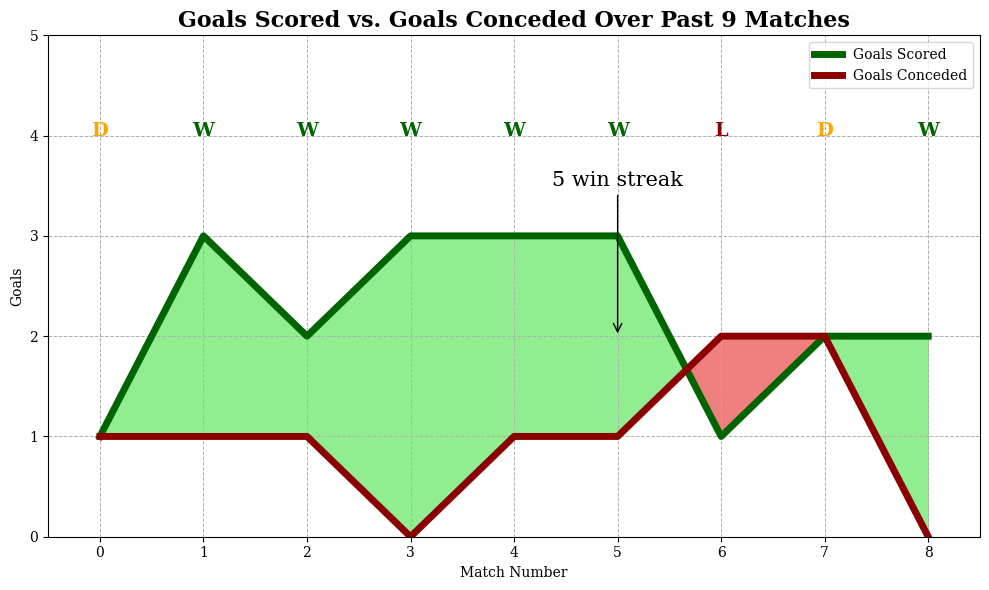

In [186]:
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import UnivariateSpline
import numpy as np

plt.rcParams["font.family"] = "serif"

def plot_goals_vs_conceded(df):
    fig, ax = plt.subplots(figsize=(10, 6))
    x = df.index

    ax.plot(x, df['Goals'], label='Goals Scored', color='darkgreen', linestyle='-', linewidth=5)
    ax.plot(x, df['2nd_half_conceded'], label='Goals Conceded', color='darkred', linestyle='-', linewidth=5)

    ax.fill_between(x, df['Goals'], df['2nd_half_conceded'], 
                    where=(df['Goals'] > df['2nd_half_conceded']), 
                    interpolate=True, color='lightgreen')
    ax.fill_between(x, df['Goals'], df['2nd_half_conceded'], 
                    where=(df['Goals'] <= df['2nd_half_conceded']), 
                    interpolate=True, color='lightcoral')

    for idx, row in df.iterrows():
        if row['Goals'] > row['2nd_half_conceded']:
            ax.text(idx, max(df['Goals'].max(), df['2nd_half_conceded'].max()) + 1, 'W', color='darkgreen', ha='center',fontsize=14,weight='bold')
        elif row['Goals'] == row['2nd_half_conceded']:
            ax.text(idx, max(df['Goals'].max(), df['2nd_half_conceded'].max()) + 1, 'D', color='orange', ha='center',fontsize=14,weight='bold')
        else:
            ax.text(idx, max(df['Goals'].max(), df['2nd_half_conceded'].max()) + 1, 'L', color='darkred', ha='center',fontsize=14,weight='bold')

    ax.set_title(f'Goals Scored vs. Goals Conceded Over Past {len(df)} Matches', fontsize=16, weight='bold')
    ax.set_xlabel('Match Number')
    ax.set_ylabel('Goals')
    ax.legend()

    ax.set_xlim(df.index.min() - 0.5, df.index.max() + 0.5)
    ax.set_ylim(0, max(df['Goals'].max(), df['2nd_half_conceded'].max()) + 2)
    ax.grid(True, which='both', linestyle='--', linewidth=0.7, color='#b0b0b0')

    # Annotating the first big green space with "5 win streak"
    win_streak = (df['Goals'] > df['2nd_half_conceded']).astype(int)
    win_streak = win_streak * (win_streak.groupby((win_streak != win_streak.shift()).cumsum()).cumcount() + 1)
    max_streak_row = win_streak.idxmax()
    if win_streak[max_streak_row] >= 5:
        ax.annotate(f'{win_streak[max_streak_row]} win streak', 
                    xy=(max_streak_row, df['Goals'][max_streak_row]/1.5),
                    xytext=(max_streak_row, df['Goals'][max_streak_row]/2 + 2), 
                    arrowprops=dict(facecolor='black', arrowstyle='->'),
                    ha='center', fontsize=15)

    plt.tight_layout()
    plt.show()

plot_goals_vs_conceded(liverpool[['Goals','2nd_half_conceded']])


In [267]:
def plot_shooting_analysis_improved(team1_data, team2_data, team1_name='Liverpool', team2_name='Spurs'):
    df1 = pd.DataFrame(team1_data, index=[team1_name])
    df2 = pd.DataFrame(team2_data, index=[team2_name])

    accuracy_metrics = ['Blocked', 'Off Target', 'On Target']
    accuracy_percentages = {}
    type_metrics = ['Insidebox', 'Outsidebox']
    type_percentages = {}

    for team, data in zip([team1_name, team2_name], [team1_data, team2_data]):
        for metric in accuracy_metrics:
            key = f'{metric} {team}'
            accuracy_percentages[key] = (data[f'Shots {metric}'] / data['Shots Total']) * 100
        for metric in type_metrics:
            key = f'{metric} {team}'
            type_percentages[key] = (data[f'Shots {metric}'] / data['Shots Total']) * 100

    colors_accuracy = {
        'Blocked': '#D32F2F',
        'Off Target': '#FBC02D',
        'On Target': '#388E3C'
    }

    colors_type = {
        'Insidebox': '#1976D2',
        'Outsidebox': '#8E24AA'
    }

    fig = make_subplots(rows=1, cols=2, shared_yaxes=True, subplot_titles=('Shooting Accuracy (%)', 'Shot Location (%)'))

    for metric in accuracy_metrics:
        y_values = [accuracy_percentages[f'{metric} {team1_name}'], accuracy_percentages[f'{metric} {team2_name}']]
        fig.add_trace(go.Bar(
            x=[team1_name, team2_name],
            y=y_values,
            name=metric,
            marker_color=colors_accuracy[metric],
            text=[f'{val:.2f}%' for val in y_values],  # Formatting values to 2 decimal places
            hoverinfo='text+name'
        ), row=1, col=1)

    for metric in type_metrics:
        y_values = [type_percentages[f'{metric} {team1_name}'], type_percentages[f'{metric} {team2_name}']]
        fig.add_trace(go.Bar(
            x=[team1_name, team2_name],
            y=y_values,
            name=metric,
            marker_color=colors_type[metric],
            text=[f'{val:.2f}%' for val in y_values],  # Formatting values to 2 decimal places
            hoverinfo='text+name'
        ), row=1, col=2)

    fig.update_layout(
        barmode='stack',
        title=f'Shooting Analysis: {team1_name} vs. {team2_name}',
        title_font=dict(size=24, family='Arial, Helvetica, sans-serif'),
        yaxis_title='Percentage (%)',
        plot_bgcolor='#2C3E50',  # Darker Background
        paper_bgcolor='#2C3E50', # Darker Background
        bargap=0.3,
        font=dict(family='Arial, Helvetica, sans-serif', size=12, color='#ECF0F1')  # Font color contrasting with background
    )

    fig.update_yaxes(title_standoff=12, showgrid=True, gridwidth=0.5, gridcolor='#7F8C8D', tickfont=dict(color='#ECF0F1'), titlefont=dict(color='#ECF0F1'))
    fig.update_xaxes(title_standoff=12, tickfont=dict(color='#ECF0F1'), titlefont=dict(color='#ECF0F1'))

    fig.show()

    
team1_data = liverpool[["Shots Total","Shots Insidebox",'Shots Blocked','Shots Outsidebox','Shots Off Target','Shots On Target']].sum()
team2_data = spurs[["Shots Total","Shots Insidebox",'Shots Blocked','Shots Outsidebox','Shots Off Target','Shots On Target']].sum()
team2_data['Shots Off Target']-=3
plot_shooting_analysis_improved(team1_data, team2_data, 'Liverpool', 'Spurs')


In [261]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import ColumnDataSource, HoverTool
from bokeh.layouts import column
from bokeh.palettes import Spectral
from bokeh.palettes import Colorblind  # A diverging palette
from bokeh.transform import linear_cmap
from bokeh.models import ColorBar
from bokeh.layouts import layout


from bokeh.io import output_notebook, show
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource, HoverTool, ColorBar, LinearColorMapper
from bokeh.transform import linear_cmap
from bokeh.palettes import RdBu11
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from bokeh.palettes import Magma256
from bokeh.models import LinearColorMapper
from bokeh.palettes import RdYlGn


liverpool = pd.read_csv('liverpool.csv')

liverpool.columns

spurs = pd.read_csv('spurs.csv')

spurs.columns

def analyze_football_data(df_original:pd.DataFrame,team_name:str):
    df = df_original.copy()

    df['Fouled Against'] = df['Free Kicks'] + df['Penalties']
    df['Set Pieces'] = df['Free Kicks'] + df['Penalties'] + df['Corners']
    df['Defensive Actions'] = df['Tackles'] + df['Shots Blocked'] + df['Successful Interceptions'] + df['Challenges']
    df['Discipline'] = df['Redcards'] + df['Yellowcards'] + df['Fouls']
    df['Aerial Dominance'] = df['Successful Headers'] / df['Headers']

    columns_to_drop = ['Corners', 'Throwins', 'Free Kicks', 'Tackles', 'Shots Blocked', 'Challenges', 'Successful Interceptions', 'Redcards', 'Yellowcards', 
                       'Fouls', 'Headers', 'Successful Headers']
    df.drop(columns=columns_to_drop, inplace=True, errors='ignore')

    df_numerical = df.select_dtypes(include=[np.number])
    df = df_numerical.iloc[:-1].drop(columns=['1st_half_scored', '2nd_half_scored', '1st_half_conceded', '2nd_half_conceded'])

    X = df.drop("Goals", axis=1)
    y = df["Goals"]

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    lasso = Lasso(alpha=0.05)
    lasso.fit(X_scaled, y)
    coefficients = pd.Series(lasso.coef_, index=X.columns)
    important_coeffs = coefficients[coefficients != 0].sort_values(key=lambda x: abs(x), ascending=True)
    coefficients = important_coeffs.to_dict()

    features = list(coefficients.keys())
    values = list(coefficients.values())
    reds = RdYlGn[11][:5][::-1]  
    greens = RdYlGn[11][6:][::-1]      # Extract the green shades
    palette = greens + reds      # Combine the palettes
    mapper = linear_cmap(field_name='values', palette=palette, low=-max(values), high=max(values))
    source = ColumnDataSource(data=dict(features=features, values=values))

    output_notebook()
    p = figure(y_range=features, height=300, width=700, title="Feature Coefficients", toolbar_location="above", tools="pan,wheel_zoom,reset")
    p.hbar(y='features', left=0, right='values', height=0.4, source=source, color=mapper)

    color_bar = ColorBar(color_mapper=mapper['transform'], width=8, location=(0,0))
    p.add_layout(color_bar, 'right')

    hover = HoverTool()
    hover.tooltips = [("Feature", "@features"), ("Coefficient", "@values")]
    p.add_tools(hover)
    p.xaxis.axis_label = "Coefficient Value"
    p.yaxis.axis_label = "Features"
    p.title.text = f'Impact of Features on {team_name}\'s Goals'

    p.title.text_font_size = '16pt'
    p.xaxis.axis_label_standoff = 12
    p.yaxis.axis_label_standoff = 12
    p.line([0, 0], [0, len(features)], line_width=2, color='black', line_dash='dashed')

    show(p)


In [262]:
analyze_football_data(spurs,"Spurs")

Loading BokehJS ...

In [264]:
analyze_football_data(liverpool,"Liverpool")

Loading BokehJS ...

In [105]:
#player stats

def get_player_stats(player_id:int):
    url = f"https://api.sportmonks.com/v3/football/players/{player_id}?api_token={api_token}&include=statistics.details.type&filters=playerStatisticSeasons:21646"
    response = requests.get(url)
    data = response.json()
    player_statistics = data['data']['statistics'][0]['details']

    stats_dict = {
        stat['type']['name']: stat['value']['total'] if isinstance(stat['value'], dict) and 'total' in stat['value'] else stat['value']
        for stat in player_statistics
    }
    
    return stats_dict

get_player_stats(1743)

{'Captain': 7,
 'Shots Total': 8,
 'Fouls': 3,
 'Shots Blocked': 1,
 'Hit Woodwork': 1,
 'Tackles': 8,
 'Assists': 2,
 'Passes': 410,
 'Redcards': 1,
 'Yellowcards': 1,
 'Shots On Target': 1,
 'Goals Conceded': 8,
 'Fouls Drawn': 1,
 'Blocked Shots': 9,
 'Interceptions': 12,
 'Clearances': 40,
 'Total Duels': 52,
 'Duels Won': 40,
 'Aerials Won': 31,
 'Accurate Passes': 381,
 'Key Passes': 5,
 'Rating': {'average': 7.37, 'highest': 8.47, 'lowest': 4.79},
 'Minutes Played': 568,
 'Long Balls': 24,
 'Long Balls Won': 16,
 'Appearances': 7,
 'Lineups': 7,
 'Big Chances Created': 2,
 'Big Chances Missed': 1,
 'Accurate Passes Percentage': 92.93}